## Imports

In [54]:
dataset = 'USPTO_STEREO'

import sys
import os
# sys.path.append('/usr/local/lib/python3.7/site-packages/') 
# for Colab 

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdChemReactions
from rdkit.Chem import rdmolops
from rdkit import DataStructs
import numpy as np

import matplotlib.pyplot as plt
params = {'text.usetex': True, 
          'text.latex.unicode': True,
          'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 6
plt.rcParams["text.latex.preamble"] = [
    r'\usepackage{siunitx}',
    r'\sisetup{detect-all}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
    r'\usepackage{helvet}',
    r'\usepackage{sansmath}',
    r'\sansmath'
]

from itertools import chain, compress
import random
random.seed(0)
from tqdm import tqdm
import csv
import re 
import pickle

# from rdkit.Chem import PandasTools
# import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', 500)

## Load USPTO_STEREO
https://ibm.ent.box.com/v/ReactionSeq2SeqDataset <br> 
use this to clean https://github.com/Hanjun-Dai/GLN/blob/master/gln/data_process/clean_uspto.py <br>

parts of code were inspired by following notebooks:<br>
https://github.com/connorcoley/rexgen_direct/blob/master/notebooks/Data%20set%20analysis.ipynb <br>
https://github.com/Hanjun-Dai/GLN/tree/master/gln/data_process <br>
https://github.com/tentrillion/rdkit-tutorials/blob/master/notebooks <br>
### first, print first few rows of csv

In [83]:
with open(os.getcwd()+'/data/US_patents_1976-Sep2016_1product_reactions_{}.csv'.format('test'), 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    header = next(reader)
    print(header)
    print(next(reader))
    print(next(reader))
    print(next(reader))

['# Original data downloaded from: https://figshare.com/articles/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873, Sept 2017']
['# Author of original data: Daniel Lowe, License: CC0, DOI: 10.6084/m9.figshare.5104873.v1']
['Source', 'Target', 'CanonicalizedReaction', 'OriginalReaction', 'PatentNumber', 'ParagraphNum', 'Year', 'TextMinedYield', 'CalculatedYield']
['C S ( = O ) ( = O ) Cl . O C C C Br > A_CCN(CC)CC A_CCOCC', 'C S ( = O ) ( = O ) O C C C Br', 'CS(=O)(=O)Cl.OCCCBr>CCN(CC)CC.CCOCC>CS(=O)(=O)OCCCBr', '[Br:1][CH2:2][CH2:3][CH2:4][OH:5].[CH3:6][S:7](Cl)(=[O:9])=[O:8].CCOCC>C(N(CC)CC)C>[CH3:6][S:7]([O:5][CH2:4][CH2:3][CH2:2][Br:1])(=[O:9])=[O:8]', 'US03930836', '', '1976', '', '']


### Clean the USPTO_STEREO data

In [135]:
def get_rxn_smiles(mol_prod, reactants, original_reagents, remove_mapping=True):
    '''
    Adapted func from Hanjun Dai's GLN to additionally keep track of reagents (reactants that don't appear in products)
    Gets rid of reactants when they don't contribute to the product
    original_reagents: list of reagents in OriginalReaction, each element of list = 1 reagent
    remove_mapping: whether to remove atom mapping if atom in rct is not in prod
    '''
    prod_smi = Chem.MolToSmiles(mol_prod, True)
    prod_maps = set(re.findall('\:([[0-9]+)\]', prod_smi))
    reactants_smi_list = []
    
    reagent_smi_list = []
    if original_reagents:
        reagent_smi_list.append(original_reagents)
    
    for mol in reactants:
        if mol is None:
            continue
            
        used = False
        for a in mol.GetAtoms():
            if a.HasProp('molAtomMapNumber'):
                if a.GetProp('molAtomMapNumber') in prod_maps:
                    used = True 
                    
                elif remove_mapping: # removes atom mapping if atom in reactant is not in product
                    a.ClearProp('molAtomMapNumber')
                    
        if used:
            reactants_smi_list.append(Chem.MolToSmiles(mol, True))
        else:
            reagent_smi_list.append(Chem.MolToSmiles(mol, True))
            
    reactants_smi = '.'.join(reactants_smi_list)
    
    if reagent_smi_list:
        reagents_smi = '.'.join(reagent_smi_list)
    else:
        reagents_smi = ''
        
    return '{}>{}>{}'.format(reactants_smi, reagents_smi, prod_smi)

In [143]:
def clean_data(rxn_list, rxn_set, key, 
               remove_mapping = True, 
               filename = os.getcwd()+'/data/US_patents_1976-Sep2016_1product_reactions_{}.csv'.format(key)):
    '''
    rxn_list: list to put cleaned rxn
    rxn_set: set to put cleaned rxn
    key: to be looped between 'train', 'valid', 'test'
    remove_mapping: whether to remove atom mapping if atom in rct is not in prod
    filename: directory of data csv 
    '''
    print('Processing {}'.format(key))
    
    pt = re.compile(r':(\d+)]')
    clean_list = [] # to store cleaned rxn smiles
    set_rxn = set() # to store unique rxn smiles
    bad_mapping = 0
    bad_prod = 0
    missing_map = 0
    raw_num = 0
    bad_rxn = 0
    
    with open(filename, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        next(reader) # pass first three rows of csv file
        next(reader)
        next(reader)
        
        for row in reader:
            rxn_smiles = row[3]
            all_reactants, reagents, prod = rxn_smiles.split('>')
            all_reactants = all_reactants.split()[0] # remove ' |f:1...'
            prod = prod.split()[0] # remove ' |f:1...'

            rids = ','.join(sorted(re.findall(pt, all_reactants)))
            pids = ','.join(sorted(re.findall(pt, prod)))
            if rids != pids:  # atom mapping is not 1:1
                bad_mapping += 1
                continue

            reactants = [Chem.MolFromSmiles(smi) for smi in all_reactants.split('.')]

            mol_prod = Chem.MolFromSmiles(prod)
            if mol_prod is None:  # rdkit is not able to parse the product
                bad_prod += 1
                continue
                
            # Make sure all have atom mapping
            if not all([a.HasProp('molAtomMapNumber') for a in mol_prod.GetAtoms()]):
                missing_map += 1
                continue

            raw_num += 1
            rxn_smiles = get_rxn_smiles(mol_prod, reactants, reagents, remove_mapping)
            # '{}>{}>{}'.format(reactants, reagents, product) 

            clean_list.append(rxn_smiles) #ignore PatentNumber
            set_rxn.add(rxn_smiles)

            if raw_num%40000 == 0:
                print('Extracted: {} raw rxn'.format(raw_num))

        rxn_list[key] = clean_list
        rxn_set[key] = set_rxn
        
        print('# clean rxn:', len(clean_list))
        print('# unique rxn:', len(set_rxn))
        print('bad mapping:', bad_mapping)
        print('bad prod:', bad_prod)
        print('missing map:', missing_map)
        print('raw rxn extracted:', raw_num, '\n')

In [139]:
clean_rxn = {'train': None, 'valid': None, 'test': None}
clean_rxn_set = {'train': None, 'valid': None, 'test': None} # removes duplicate rxns

for key in clean_rxn.keys():
    clean_data(clean_rxn, clean_rxn_set, key, True, 
              os.getcwd()+'/data/US_patents_1976-Sep2016_1product_reactions_{}.csv'.format(key))

Processing train
Extracted: 40000 raw rxn
Extracted: 80000 raw rxn
Extracted: 120000 raw rxn
Extracted: 160000 raw rxn
Extracted: 200000 raw rxn
Extracted: 240000 raw rxn
Extracted: 280000 raw rxn
Extracted: 320000 raw rxn
Extracted: 360000 raw rxn
Extracted: 400000 raw rxn
Extracted: 440000 raw rxn
Extracted: 480000 raw rxn
Extracted: 520000 raw rxn
Extracted: 560000 raw rxn
Extracted: 600000 raw rxn
Extracted: 640000 raw rxn
Extracted: 680000 raw rxn
Extracted: 720000 raw rxn
Extracted: 760000 raw rxn
Extracted: 800000 raw rxn
Extracted: 840000 raw rxn
# clean rxn: 865901
# unique rxn: 865898
bad mapping: 36680
bad prod: 0
missing map: 0
raw rxn extracted: 865901 

Processing valid
Extracted: 40000 raw rxn
# clean rxn: 48119
# unique rxn: 48118
bad mapping: 2012
bad prod: 0
missing map: 0
raw rxn extracted: 48119 

Processing test
Extracted: 40000 raw rxn
# clean rxn: 48165
# unique rxn: 48165
bad mapping: 2093
bad prod: 0
missing map: 0
raw rxn extracted: 48165 



### Save as pickle to avoid running this very long cleaning step again

In [140]:
with open(os.getcwd()+'/USPTO_STEREO_pickles/clean_rxn.pickle', 'wb') as handle:
    pickle.dump(clean_rxn, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.getcwd()+'/USPTO_STEREO_pickles/clean_rxn_set.pickle', 'wb') as handle:
    pickle.dump(clean_rxn_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Eyeball some rxns. 
- hydrolysis of penicillin

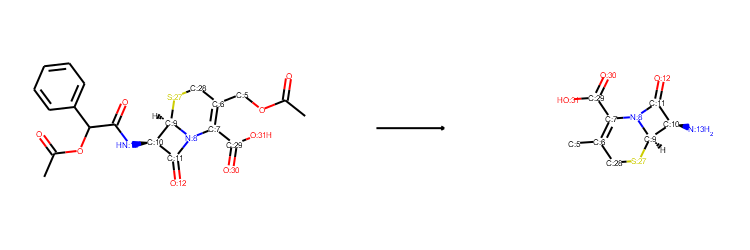

In [46]:
curr_rxn = 'CC(=O)OC(C(=O)[NH:13][C@H:10]1[C@@H:9]2[N:8]([C:7]([C:29](=[O:30])[OH:31])=[C:6]([CH2:5]OC(C)=O)[CH2:28][S:27]2)[C:11]1=[O:12])c1ccccc1>>[CH3:5][C:6]1=[C:7]([C:29](=[O:30])[OH:31])[N:8]2[C@@H:9]([C@H:10]([NH2:13])[C:11]2=[O:12])[S:27][CH2:28]1'

Draw.ReactionToImage(rdChemReactions.ReactionFromSmarts(curr_rxn, useSmiles=True), (250, 250))

### Count # of reactant fragments that end up in the product

In [144]:
from collections import Counter

num_rcts = {}
for key in clean_rxn.keys():
    num_rcts_list = [smarts.split('>')[0].count('.')+1 for smarts in clean_rxn[key]]
    num_rcts[key] = Counter(num_rcts_list)
    
    print('# reactant fragments in {}: '.format(key))
    print(num_rcts[key], '\n')

# reactant fragments in train: 
Counter({2: 599958, 1: 201929, 3: 51141, 4: 10324, 5: 2152, 6: 324, 7: 56, 8: 13, 9: 4}) 

# reactant fragments in valid: 
Counter({2: 33202, 1: 11323, 3: 2839, 4: 604, 5: 116, 6: 30, 7: 5}) 

# reactant fragments in test: 
Counter({2: 33278, 1: 11368, 3: 2826, 4: 572, 5: 107, 6: 11, 7: 2, 8: 1}) 



In [145]:
num_prods = {}
for key in clean_rxn.keys():
    num_prods_list = [smarts.split('>')[-1].count('.')+1 for smarts in clean_rxn[key]]
    num_prods[key] = Counter(num_prods_list)
    
    print('# products in {}: '.format(key))
    print(num_prods[key], '\n')

# products in train: 
Counter({1: 865901}) 

# products in valid: 
Counter({1: 48119}) 

# products in test: 
Counter({1: 48165}) 



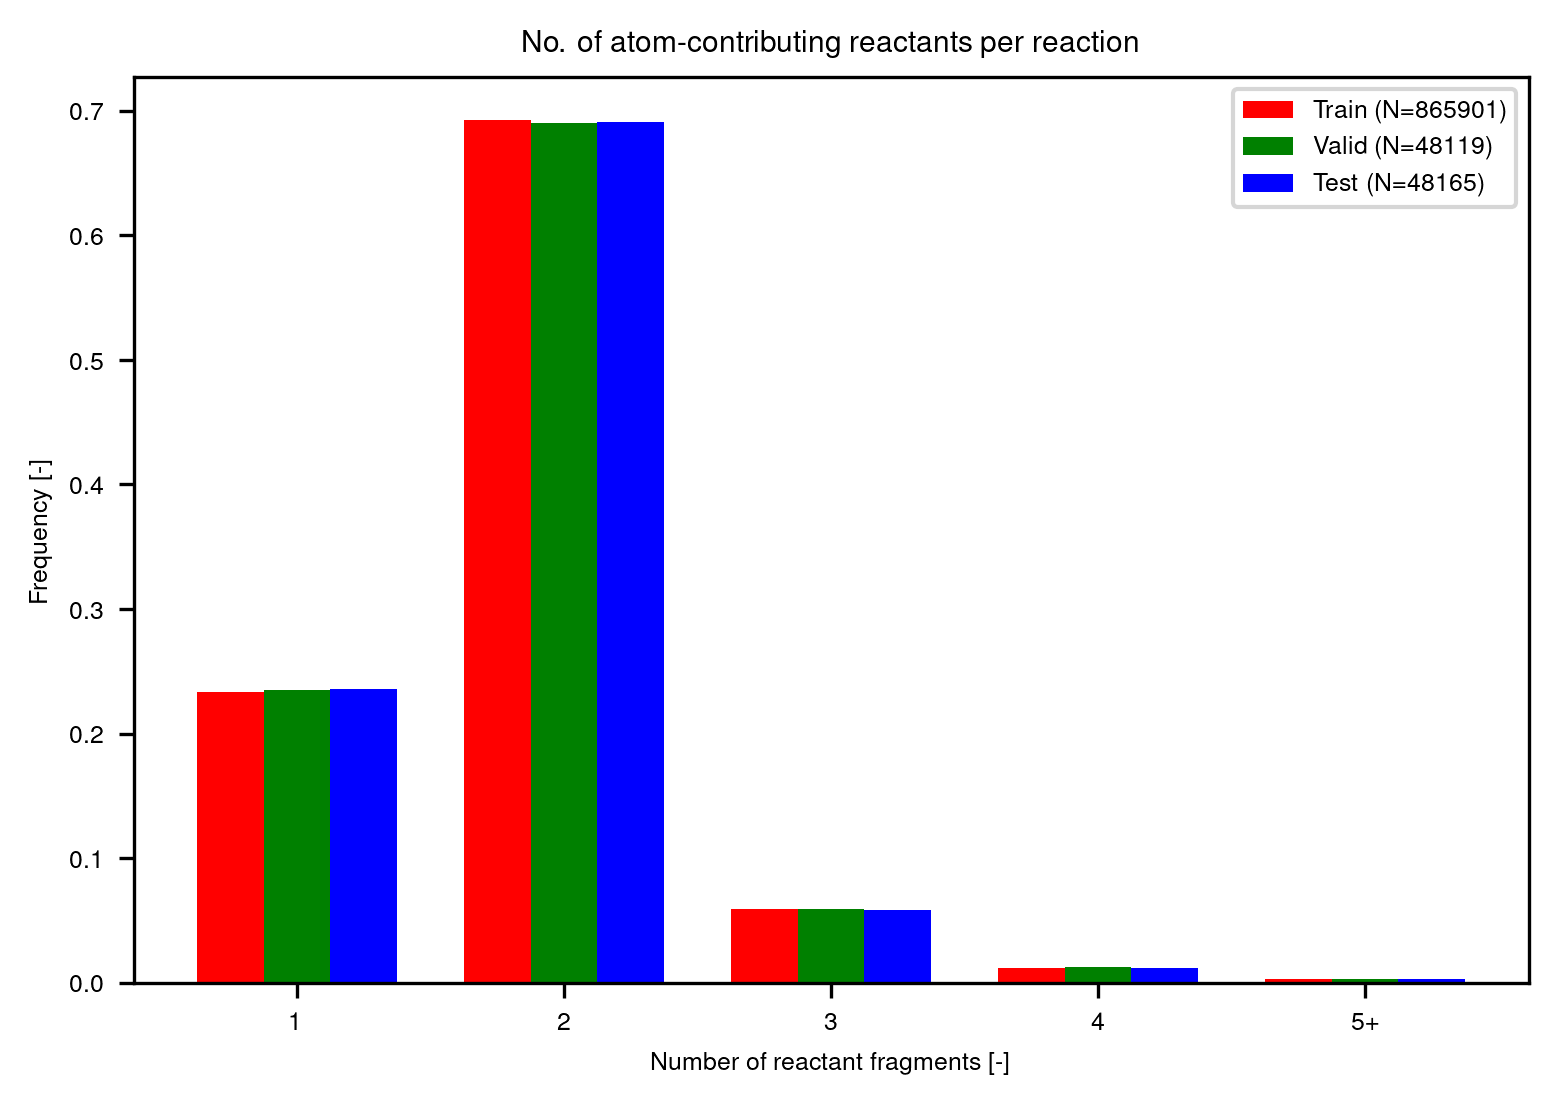

In [147]:
n = 6
dataset = 'USPTO_STEREO'
fig = plt.figure(figsize=(6,4), dpi = 300)
colors = ['r', 'g', 'b']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    counter = num_rcts[key]
    counts_sum = sum(counter.values())
    xs = np.arange(1, n)
    xs[-1] = 1e9
    counts = np.zeros(np.shape(xs))
    
    for (k, v) in sorted(counter.items(), key=lambda x: x[0], reverse=True):
        for i in range(len(counts)):
            if xs[i] >= k:
                counts[i] = counts[i] + v
                break
                
    plt.bar(np.arange(len(counts)) + (offset-1)*.25, 
            counts / counts_sum, width=0.25,
            color=colors[offset])
    
plt.xlabel('Number of reactant fragments [-]')
xticklabels = [str(k) for k in xs if k != 1e9]
xticklabels.append('{}+'.format(xs[-2]+1))
plt.xticks(range(len(counts)), xticklabels)
plt.ylabel('Frequency [-]')
plt.legend(['Train (N={})'.format(len(clean_rxn['train'])), 
            'Valid (N={})'.format(len(clean_rxn['valid'])), 
            'Test (N={})'.format(len(clean_rxn['test']))])

plt.title('No. of atom-contributing reactants per reaction') # Raised Error when I used '# of reactants' instd of #No. of
plt.savefig(os.getcwd()+'/analysis/{}_num_reactant_frags.png'.format(dataset), bbox_inches = 'tight')
plt.show()

## Print all elements in reactants. Takes a while 
https://regexr.com/ <br>

### First remove all stereo info + map all reactant (and reagent) atoms: 
- regex needs all atoms in rcts to be atom-mapped. this is NOT the case as atoms not in prod are not numbered in this database.
- SO, I can: change the regex to recognise atoms without number mappings OR 
- find a way to number all atoms in rcts --> yes, can do
<br>

steps:
- identify max atom mapping number in product
- add to this number 1 by 1 and number all unmapped atoms in reactant(s) by using ~atom.HasProp('molAtomMapNumber')

In [249]:
%%time 
# list comprehension takes 5.9 s for 10,000 runs, for loop takes 6.35 s
# for i in range(100000):
#     max_map = 0
#     for atom in example_mol.GetAtoms(): # no choice but to iterate all atoms to find max molAtomMapNumber
#         if atom.HasProp('molAtomMapNumber'):
#             curr_map = int(atom.GetProp('molAtomMapNumber'))
#             if curr_map > max_map:
#                 max_map = curr_map
                
for i in range(1000):
    max_map = max([int(atom.GetProp('molAtomMapNumber')) for atom in example_mol.GetAtoms() if atom.HasProp('molAtomMapNumber')])

Wall time: 59.9 ms


In [15]:
def remove_stereo_and_map_all_rcts(rxn_smi, do_reagent=False, keep_reagent=False):
    '''
    helper function to count # atoms by element in dataset 
    removes stereochemical information from reactants & product
    adds atom mapping to all atoms in reactants regardless of whether they appear in the product
    
    do_reagent: whether to remove stereo and map for reagents too
    keep_reagent: whether to keep reagents in original rxn_smi 
    '''
    prod_smi = rxn_smi.split('>')[-1]
    rcts_smi = rxn_smi.split('>')[0].split('.')
    
    prod_mol = Chem.MolFromSmiles(prod_smi)
    rcts_mol = [Chem.MolFromSmiles(rct_smi) for rct_smi in rcts_smi]
    rdmolops.RemoveStereochemistry(prod_mol) # remove product stereochemistry
    
    # find max atom map among all reactants 
    max_map = 0
    for rct_mol in rcts_mol:
        max_map_cand = max([int(atom.GetProp('molAtomMapNumber')) 
                       for atom in rct_mol.GetAtoms() if atom.HasProp('molAtomMapNumber') 
                       ])
        if max_map_cand > max_map:
            max_map = max_map_cand
    
    # for all reactant atoms w/o atom map, set atom map starting from max_map+1 
    for rct_mol in rcts_mol:
        rdmolops.RemoveStereochemistry(rct_mol)
        for atom in rct_mol.GetAtoms():
            if not atom.HasProp('molAtomMapNumber'):
                max_map += 1
                atom.SetAtomMapNum(max_map)
    
    # if do_reagent: repeat for reagent atoms 
    if do_reagent: 
        rgts_smi = rxn_smi.split('>')[1].split('.')
        rgts_mol = [Chem.MolFromSmiles(rgt_smi) for rgt_smi in rgts_smi]
        
        for rgt_mol in rgts_mol:
            rdmolops.RemoveStereochemistry(rgt_mol)
            for atom in rgt_mol.GetAtoms():
                if not atom.HasProp('molAtomMapNumber'):
                    max_map += 1
                    atom.SetAtomMapNum(max_map)
        
        rgts_smi = [Chem.MolToSmiles(rgt_mol, True) for rgt_mol in rgts_mol]

    prod_smi = Chem.MolToSmiles(prod_mol, True)
    rcts_smi = [Chem.MolToSmiles(rct_mol, True) for rct_mol in rcts_mol]
    
    if do_reagent:
        return '{}>{}>{}'.format('.'.join(rcts_smi), '.'.join(rgts_smi), prod_smi)
    elif keep_reagent:
        reag_smi = rxn_smi.split('>')[1]
        return '{}>{}>{}'.format('.'.join(rcts_smi), reag_smi, prod_smi)
    else:
        return '{}>>{}'.format('.'.join(rcts_smi), prod_smi)

In [55]:
with open(os.getcwd()+'/USPTO_STEREO_pickles/clean_rxn.pickle', 'rb') as handle:
    clean_rxn = pickle.load(handle)

In [19]:
%%time 

clean_rxn_allmap = {'train': None, 'valid': None, 'test': None}

for key in clean_rxn_allmap.keys():
    print('\nCleaning {}'.format(key))
    allmap_list = []
    for i, rxn_smi in enumerate(clean_rxn[key]):
        allmap_list.append(remove_stereo_and_map_all_rcts(rxn_smi, do_reagent=True))
        if (i+1)%40000 == 0:
            print('Cleaned: {} rxn SMILES'.format(i))
    clean_rxn_allmap[key] = allmap_list


Cleaning train
Cleaned: 39999 rxn SMILES
Cleaned: 79999 rxn SMILES
Cleaned: 119999 rxn SMILES
Cleaned: 159999 rxn SMILES
Cleaned: 199999 rxn SMILES
Cleaned: 239999 rxn SMILES
Cleaned: 279999 rxn SMILES
Cleaned: 319999 rxn SMILES
Cleaned: 359999 rxn SMILES
Cleaned: 399999 rxn SMILES
Cleaned: 439999 rxn SMILES
Cleaned: 479999 rxn SMILES
Cleaned: 519999 rxn SMILES
Cleaned: 559999 rxn SMILES
Cleaned: 599999 rxn SMILES
Cleaned: 639999 rxn SMILES
Cleaned: 679999 rxn SMILES
Cleaned: 719999 rxn SMILES
Cleaned: 759999 rxn SMILES
Cleaned: 799999 rxn SMILES
Cleaned: 839999 rxn SMILES

Cleaning valid
Cleaned: 39999 rxn SMILES

Cleaning test
Cleaned: 39999 rxn SMILES
Wall time: 27min 18s


In [20]:
with open(os.getcwd()+'/USPTO_STEREO_pickles/clean_rxn_allmap_nostereo.pickle', 'wb') as handle:
    pickle.dump(clean_rxn_allmap, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open(os.getcwd()+'/USPTO_STEREO_pickles/clean_rxn_allmap_nostereo.pickle', 'rb') as handle:
    clean_rxn_allmap = pickle.load(handle)

### visualise atom freq by element (takes a while)
- use clean_rxn_allmap

In [16]:
from collections import defaultdict

atom_id_rcts = {}
for key in clean_rxn_allmap.keys():
    occurrences = defaultdict(int)
    
    for smarts in clean_rxn_allmap[key]:
        rcts = smarts.split('>')[0]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rcts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_rcts[key] = occurrences

atom_id_rgts = {}
for key in clean_rxn_allmap.keys():
    occurrences = defaultdict(int)
    
    for smarts in clean_rxn_allmap[key]:
        rgts = smarts.split('>')[1]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rgts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_rgts[key] = occurrences
    
atom_id_prods = {}
for key in clean_rxn_allmap.keys():
    occurrences = defaultdict(int)
    
    for smarts in clean_rxn_allmap[key]:
        prod = smarts.split('>')[-1]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', prod, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_prods[key] = occurrences
    
all_atom_types = set()
rgt_atom_types = set()
for key in clean_rxn_allmap.keys():
    all_atom_types |= set(atom_id_rcts[key].keys()) # all atoms in rcts will appear in prods
    rgt_atom_types |= set(atom_id_rgts[key].keys())
    
all_atom_types = sorted(all_atom_types, key=lambda x: atom_id_rcts['train'][x], reverse=True)
rgt_atom_types = sorted(rgt_atom_types, key=lambda x: atom_id_rgts['train'][x], reverse=True)
print('Elements in reactants:', all_atom_types)
print(len(all_atom_types))
print('\nElements in reagents:', rgt_atom_types)
print(len(rgt_atom_types))

Elements in reactants: ['c', 'o', 'n', 'f', 'cl', 's', 'br', 'i', 'b', 'si', 'p', 'mg', 'sn', 'li', 'zn', 'cu', 'se', 'mn', 'al', 'na', 'cr', 'k', '2', 'pb', 'as', 'bi', 'ge', 'te', 'sb', 'ti', 'xe', '3', 'ru', 'zr', 'ga', 'ta', 'pt', '11c', 'in', 'tl', 'ag', 'co', 'ca', '125i', 'w', '131i', '32p']
47

Elements in reagents: ['c', 'o', 'n', 'cl', 'na', 'f', 'k', 'p', 's', 'pd', 'li', 'b', 'br', 'i', 'cs', 'al', 'si', 'cu', 'fe', 'zn', 'mg', 'ni', 'sn', 'pt', 'mn', 'ti', 'cr', 'ca', 'ag', 'ru', 'rh', 'os', 'ce', 'co', 'pb', 'ba', 'yb', 'w', 'mo', 'se', '2', 'in', 'as', 'zr', 'v', 'ir', 'bi', 'au', 'tl', 'sc', 're', 'sb', 'sm', 'cd', 'la', 'rb', 'ta', '3', 'y', 'pr', 'te', 'dy', 'ga', 'ar', 'eu', 'gd', '13c', 'ge', '131i', 'sr', '18f', 'nd', 'tc', '11c', '1', '123i', '13n', 'be', '15o', '125i', '14c', 'er', '60co']
83


### why are there keys: '2' (79 counts in train), '3' (9 counts in train), '125i', '11c', '32p', '131i' ? Answer: Isotopes! 
- 2: Deuterium? 3: Tritium? 


Freq Carbon in train: 71.18%
Freq Carbon in valid: 71.20%
Freq Carbon in test: 71.21%


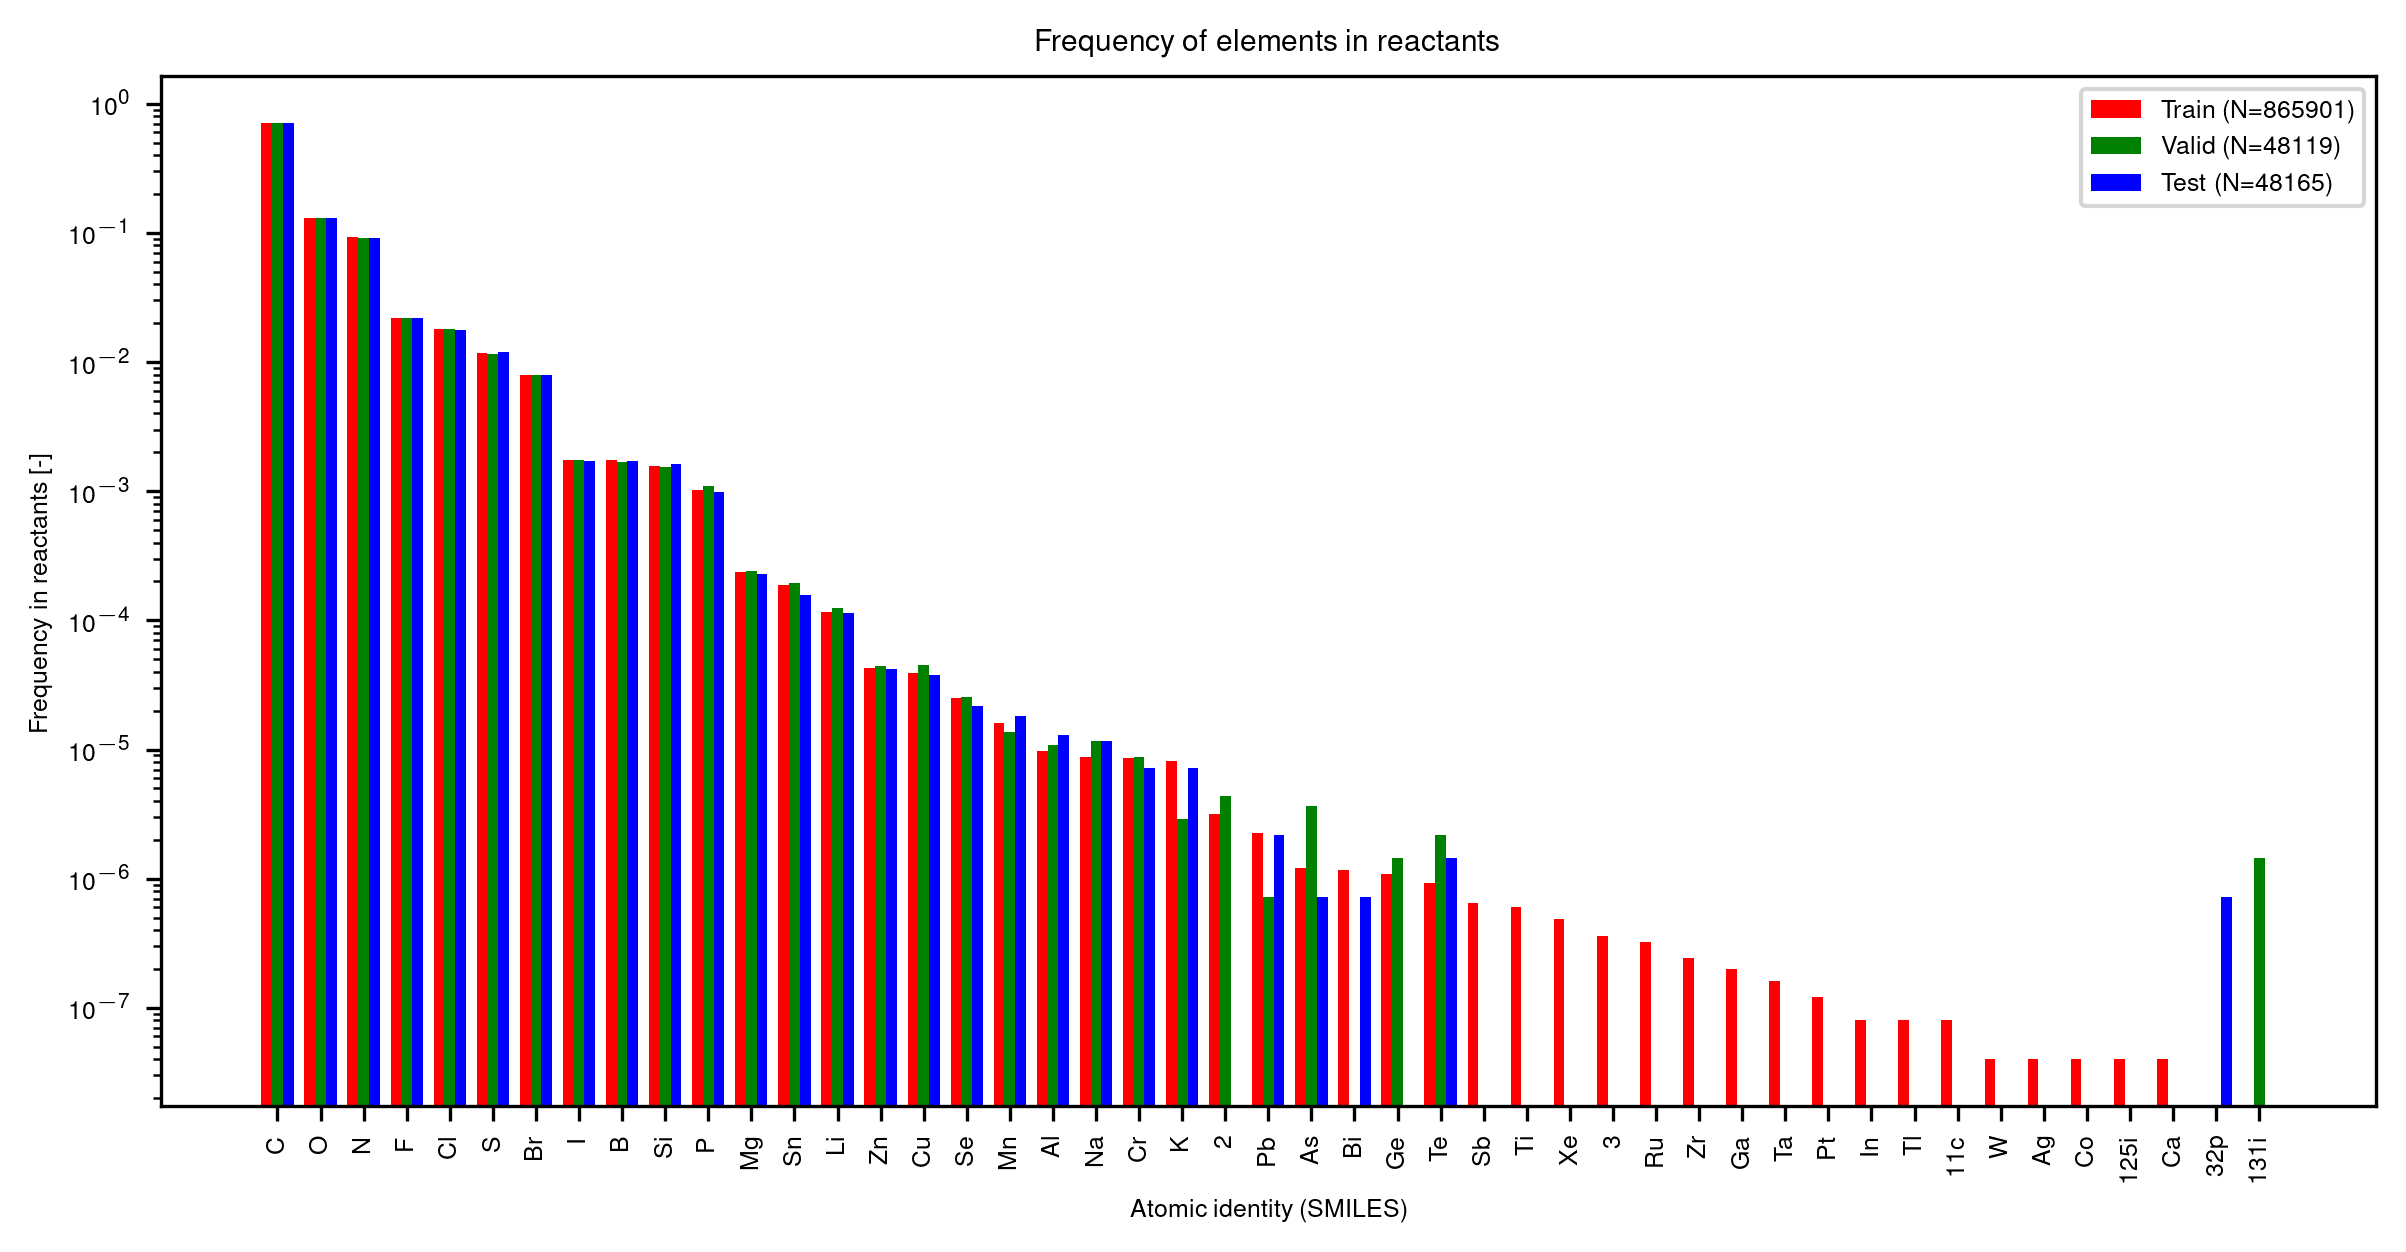

In [285]:
fig = plt.figure(figsize=(8,4), dpi = 300)
colors = ['r', 'g', 'b']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    vals = []
    for atom_type in all_atom_types:
        vals.append(atom_id_rcts[key][atom_type])
    vals = np.array(vals)
        
    plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
            vals / np.sum(vals), width=0.25,
            color=colors[offset])
    print('Freq Carbon in {}: {:.2f}%'.format(key, 100*vals[0]/np.sum(vals)))
    
plt.xlabel('Atomic identity (SMILES)')
plt.xticks(range(len(vals)), 
           ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
          rotation='vertical')
plt.ylabel('Frequency in reactants [-]')
# plt.grid(True)
plt.legend(['Train (N={})'.format(len(clean_rxn_allmap['train'])), 
            'Valid (N={})'.format(len(clean_rxn_allmap['valid'])), 
            'Test (N={})'.format(len(clean_rxn_allmap['test']))])
plt.yscale('log')
plt.tight_layout()
plt.title('Frequency of elements in reactants')
plt.savefig(os.getcwd()+'/analysis/{}_atom_type_freqs.png'.format(dataset), bbox_inches = 'tight')
plt.show()

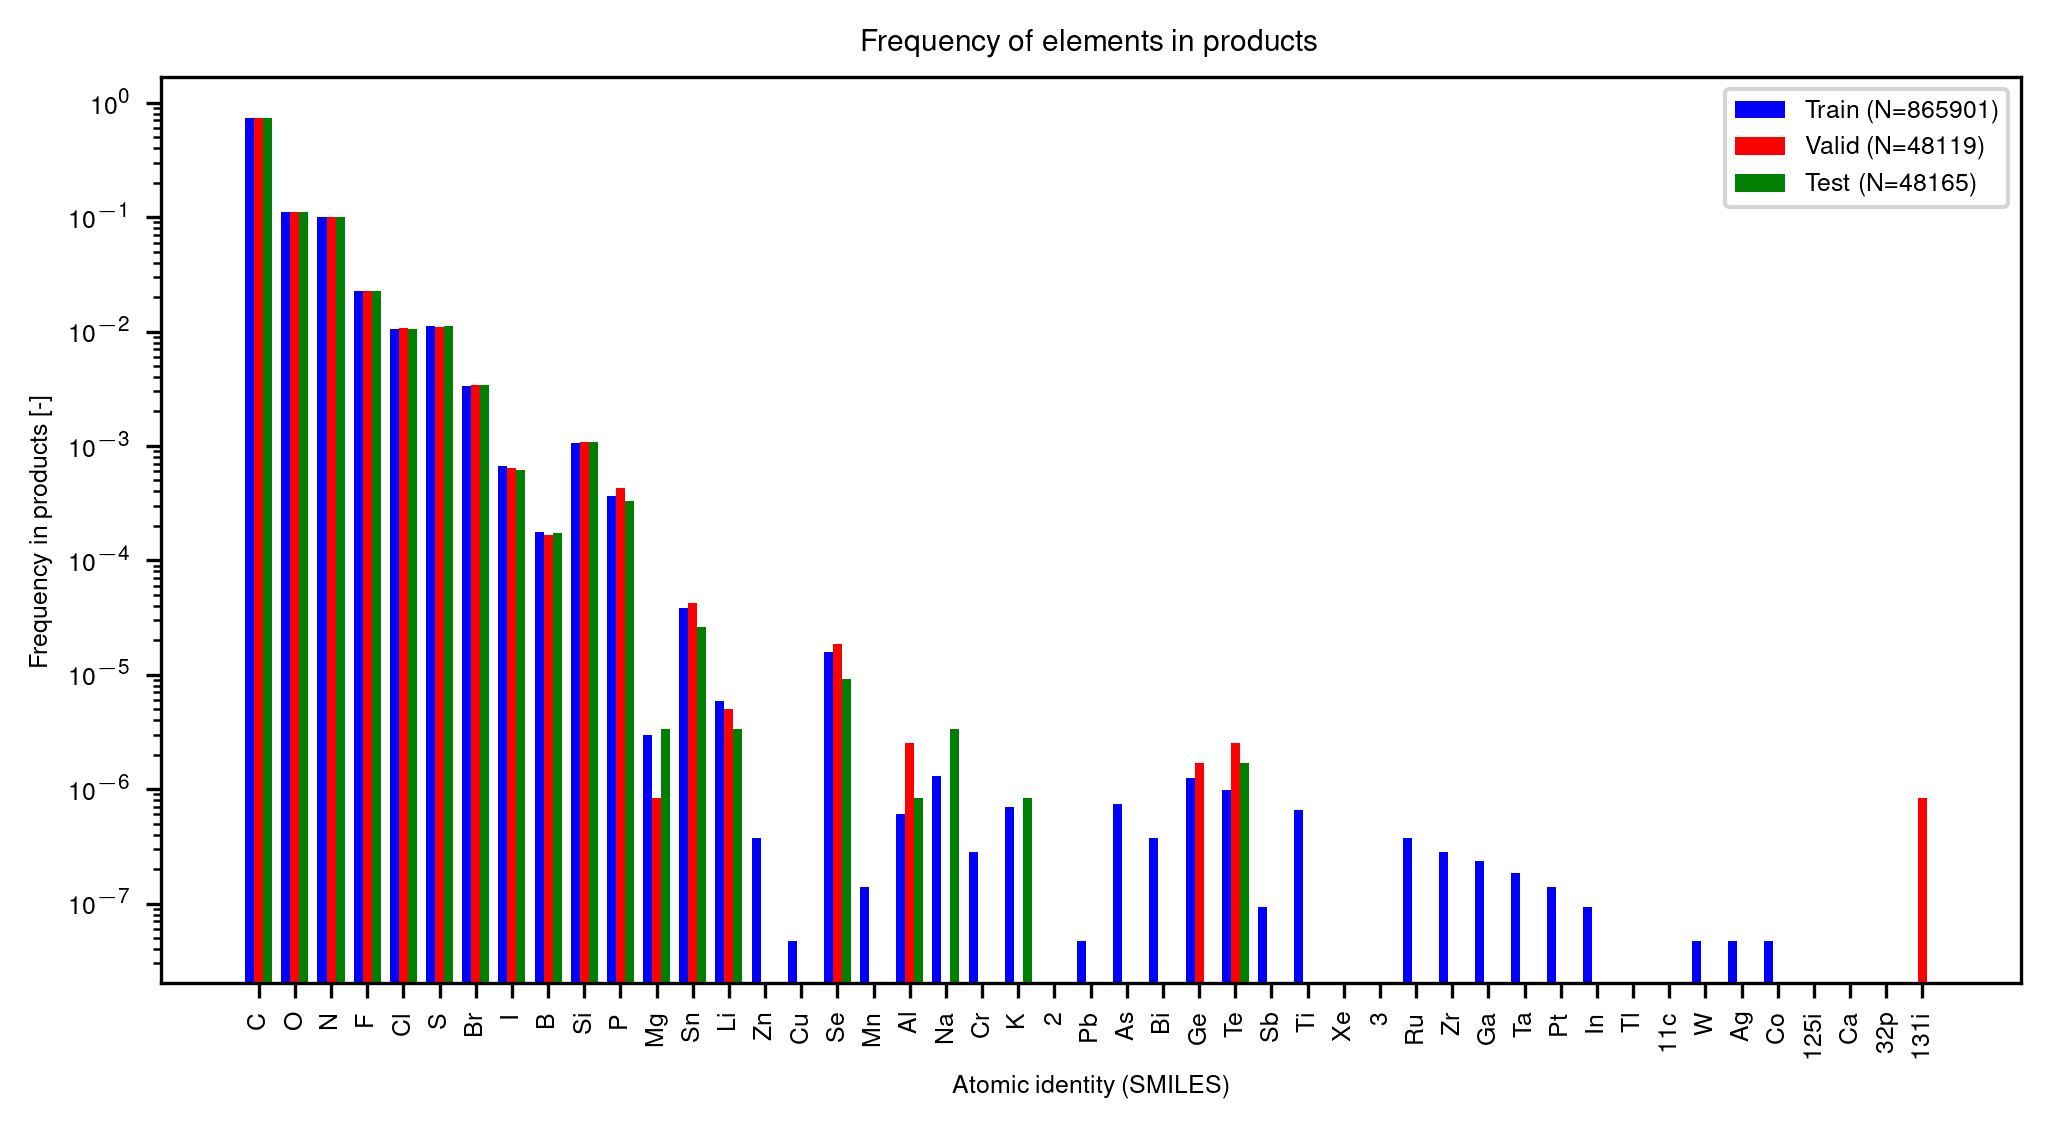

In [283]:
fig = plt.figure(figsize=(8,4), dpi = 300)
colors = ['b', 'r', 'g']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    vals = []
    for atom_type in all_atom_types:
        vals.append(atom_id_prods[key][atom_type])
    vals = np.array(vals)
        
    plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
            vals / np.sum(vals), width=0.25,
            color=colors[offset])
    
plt.xlabel('Atomic identity (SMILES)')
plt.xticks(range(len(vals)), 
           ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
          rotation='vertical')
plt.ylabel('Frequency in products [-]')
# plt.grid(True)
plt.legend(['Train (N={})'.format(len(clean_rxn_allmap['train'])), 
            'Valid (N={})'.format(len(clean_rxn_allmap['valid'])), 
            'Test (N={})'.format(len(clean_rxn_allmap['test']))])
plt.yscale('log')
plt.title('Frequency of elements in products')
plt.savefig(os.getcwd()+'/analysis/{}_atom_type_freqs_prods.png'.format(dataset), bbox_inches = 'tight')
plt.show()

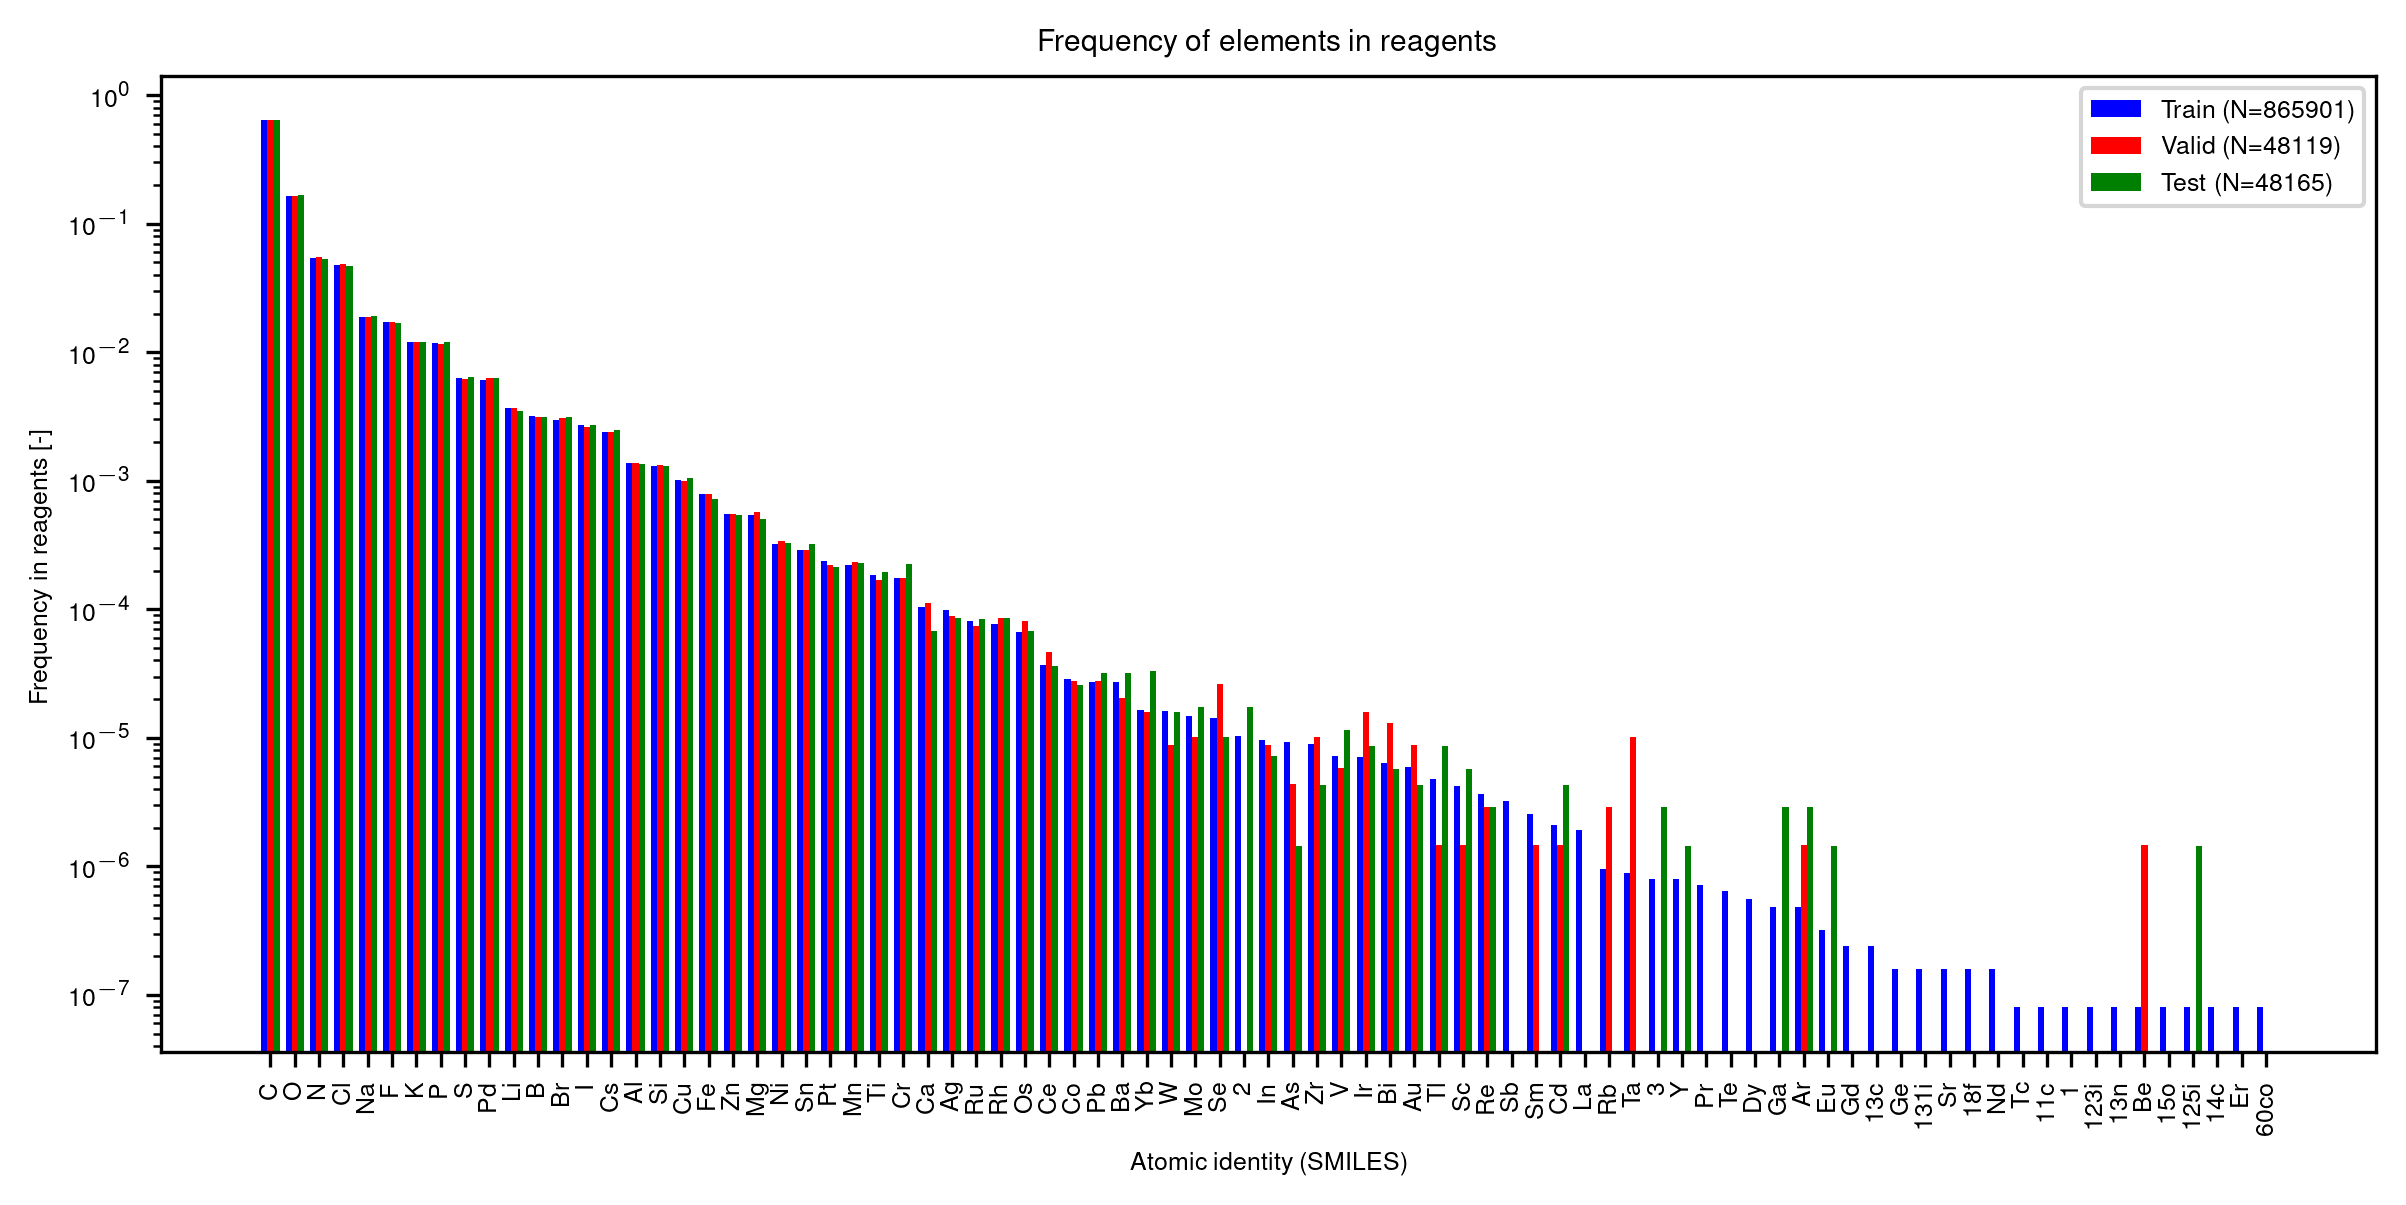

In [14]:
fig = plt.figure(figsize=(8,4), dpi = 300)
colors = ['b', 'r', 'g']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    vals = []
    for atom_type in rgt_atom_types:
        vals.append(atom_id_rgts[key][atom_type])
    vals = np.array(vals)
        
    plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
            vals / np.sum(vals), width=0.25,
            color=colors[offset])
    
plt.xlabel('Atomic identity (SMILES)')
plt.xticks(range(len(vals)), 
           ['{}{}'.format(a[0].upper(), a[1:]) for a in rgt_atom_types],
          rotation='vertical')
plt.ylabel('Frequency in reagents [-]')
# plt.grid(True)
plt.legend(['Train (N={})'.format(len(clean_rxn_allmap['train'])), 
            'Valid (N={})'.format(len(clean_rxn_allmap['valid'])), 
            'Test (N={})'.format(len(clean_rxn_allmap['test']))])
plt.yscale('log')
plt.title('Frequency of elements in reagents')
plt.tight_layout()
plt.savefig(os.getcwd()+'/analysis/{}_atom_type_freqs_rgts.png'.format(dataset), bbox_inches = 'tight')
plt.show()

### Calculate unique # products, unique # reactants, unique # reagents

In [148]:
products = {}
for key in clean_rxn.keys():
    products[key] = [smarts.split('>')[-1] for smarts in clean_rxn[key]]

unique_products = {}
for key in clean_rxn.keys():
    unique_products[key] = set(products[key])
    
    print('# reactions in {}: {}'.format(key, len(products[key])))
    print('# unique pdts in {}: {} \n'.format(key, len(unique_products[key])))

# reactions in train: 865901
# unique pdts in train: 843743 

# reactions in valid: 48119
# unique pdts in valid: 47047 

# reactions in test: 48165
# unique pdts in test: 47028 



In [149]:
reactants = {}
for key in clean_rxn.keys():
    reactants[key] = [smarts.split('>')[0].split('.') for smarts in clean_rxn[key]]
    
unique_reactants = {}
for key in clean_rxn.keys():
    unique_reactants[key] = set(chain.from_iterable(reactants[key]))
    
    print('# reactions in {}: {}'.format(key, len(reactants[key])))
    print('# total reactants in {}: {}'.format(key, len(list(chain.from_iterable(reactants[key])))))
    print('# unique reactants in {}: {} \n'.format(key, len(unique_reactants[key])))

# reactions in train: 865901
# total reactants in train: 1609800
# unique reactants in train: 949362 

# reactions in valid: 48119
# total reactants in valid: 89455
# unique reactants in valid: 75002 

# reactions in test: 48165
# total reactants in test: 89313
# unique reactants in test: 74480 



In [195]:
reagents = {}
for key in clean_rxn.keys():
    reagents[key] = [smarts.split('>')[1].split('.') for smarts in clean_rxn[key]]
    
unique_reagents = {}
for key in clean_rxn.keys():
    unique_reagents[key] = set(chain.from_iterable(reagents[key]))
    
    print('# reactions in {}: {}'.format(key, len(reagents[key])))
    print('# total reagents in {}: {}'.format(key, len(list(chain.from_iterable(reagents[key])))))
    print('# unique reagents in {}: {} \n'.format(key, len(unique_reagents[key])))

# reactions in train: 865901
# total reagents in train: 2878011
# unique reagents in train: 32217 

# reactions in valid: 48119
# total reagents in valid: 158946
# unique reagents in valid: 4166 

# reactions in test: 48165
# total reagents in test: 159937
# unique reagents in test: 4274 



### check most commonly occuring reagents
- not perfect, bcos ions are separately represented (e.g. [Na+] rather than 1 entity as NaOH) when split by '.'

In [56]:
from collections import defaultdict

all_rgts = {}
for key in clean_rxn.keys():
    occurrences = defaultdict(int)
    
    for smarts in clean_rxn[key]:
        rgts = smarts.split('>')[1].split('.')
    
        for rgt in rgts:
            occurrences[rgt] += 1        
    all_rgts[key] = occurrences
    
uniq_rgts = set()
for key in clean_rxn_allmap.keys():
    uniq_rgts |= set(all_rgts[key].keys()) 
    
uniq_rgts = sorted(uniq_rgts, key=lambda x: all_rgts['train'][x], reverse=True)
top50_rgts = uniq_rgts[:50]
print('Top 50 reagents:', top50_rgts)
print(len(uniq_rgts))

Top 50 reagents: ['[Na+]', 'O', '[K+]', 'Cl', '', 'CO', '[OH-]', 'O=C([O-])[O-]', 'C1COCC1', '[H-]', 'C(Cl)Cl', 'CN(C=O)C', 'ClCCl', 'CCN(CC)CC', '[Cl-]', 'O1CCCC1', 'C(O)C', 'CN(C)C=O', '[Pd]', 'C(OCC)(=O)C', 'C1(C)C=CC=CC=1', 'CCN(C(C)C)C(C)C', '[Cs+]', '[Li+]', 'CCOC(C)=O', 'O1CCOCC1', 'O=C([O-])O', 'C(#N)C', '[NH4+]', 'C1C=CC(/C=C/C(/C=C/C2C=CC=CC=2)=O)=CC=1', 'C(O)(=O)C', 'O=C(O)C(F)(F)F', 'CCO', 'CS(C)=O', 'CCOCC', 'F[P-](F)(F)(F)(F)F', 'CCCCCC', '[BH4-]', 'C(Cl)(Cl)Cl', '[Al+3]', 'C([O-])(=O)C', 'N1C=CC=CC=1', 'C1C=CC([P]([Pd]([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)[P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)=CC=1', 'CC(C)=O', '[Li]CCCC', 'CC(=O)O', 'CCN=C=NCCCN(C)C', 'c1ccncc1', 'On1nnc2ccccc21', '[H][H]']
34802


### Draw.MolsToGridImage doesn't work :/ Tried useSVG=False & raised error 

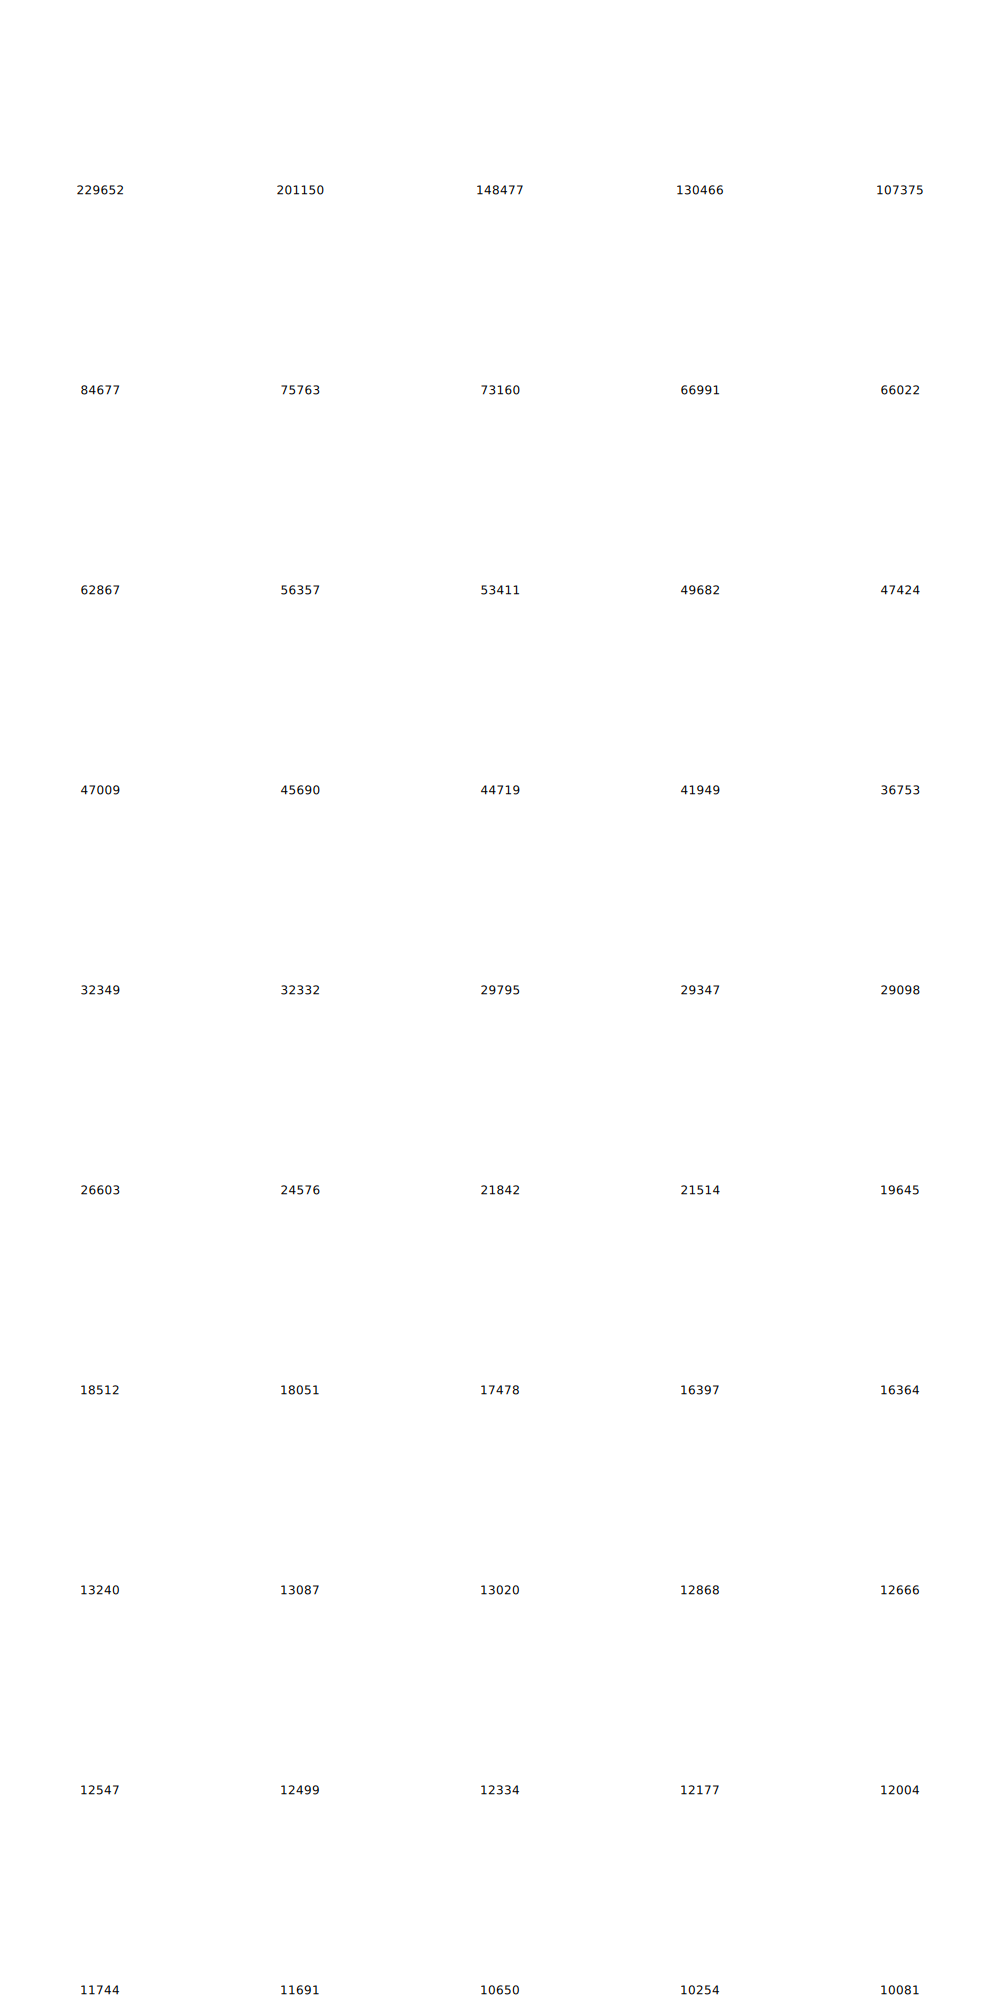

In [63]:
top50_rgts_mol = [Chem.MolFromSmiles(rgt) for rgt in top50_rgts]

Draw.MolsToGridImage(top50_rgts_mol, molsPerRow=5, 
                           subImgSize=(200,200), 
                           legends=[str(all_rgts['train'][x]) for x in top50_rgts],
                    useSVG=True) 

### possible Suzuki couplings (to do: find better way of finding specific rxn: prolly by using SMARTS tokens or using the bond edits data)
- m.HasSubstructMatch(Chem.MolFromSmiles('CB')) to find carbon bonded to B 

In [17]:
B_rxn = {}
for key in clean_rxn.keys():
    # check for B or b not followed by [a-z] & not preceded by [a-z]/[A-Z] in reactants
    B_mask = [re.search("B(?![a-z])|(?<![A-Z])b(?![a-z])", rxn_smi.split('>')[0]) for rxn_smi in clean_rxn[key]]
    B_rxn[key] = list(compress(clean_rxn[key], B_mask))
    
    suzuki_count = sum( (('Pd' in rxn_smi) or ('Ni' in rxn_smi) or ('Fe' in rxn_smi) or 
                        ('Cu' in rxn_smi) or ('Ru' in rxn_smi))  # common suzuki catalysts 
                       for rxn_smi in B_rxn[key] )
    
    print('likely Suzuki coupling in {}: {:.3f}%'.format(key,
                                                         100 * suzuki_count / len(clean_rxn[key])))
    print('# rxn in {}: {} \n'.format(key, suzuki_count))

likely Suzuki coupling in train: 2.402%
# rxn in train: 20796 

likely Suzuki coupling in valid: 2.344%
# rxn in valid: 1128 

likely Suzuki coupling in test: 2.510%
# rxn in test: 1209 



### Randomly selects a rxn fitting specified criteria
- Saw a rxn where the atom mapping is wrong...carbon in product doesn't come from $PPh_{3}$...should be from the 2-propylene bromide. But don't know how to get rid of those rxn

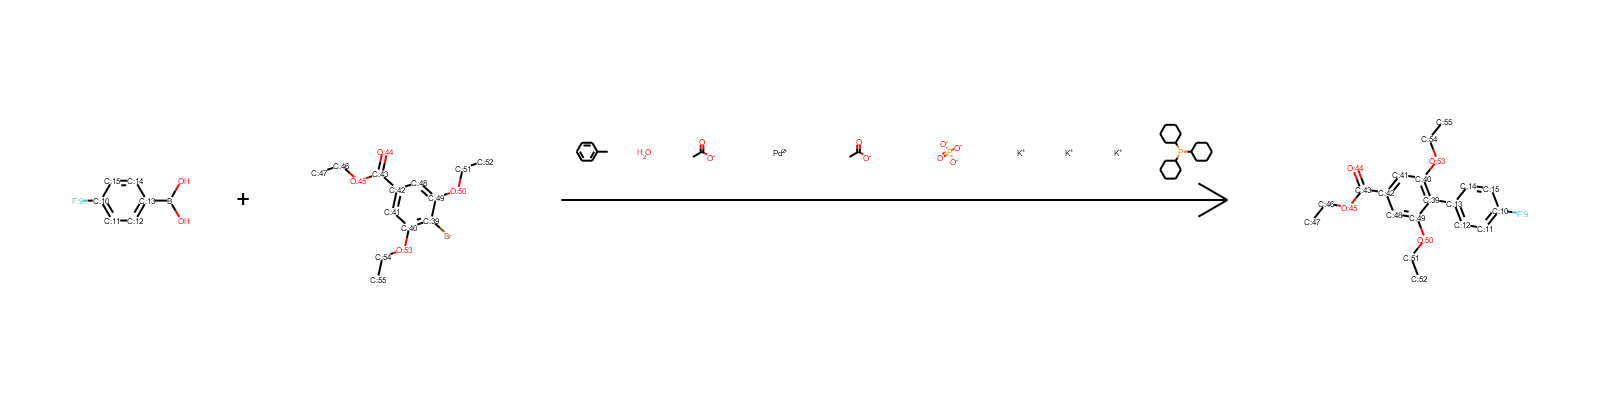

In [286]:
key = 'train'
suzuki_catalyst_mask = [(('Pd' in rxn_smi) or ('Ni' in rxn_smi) or ('Fe' in rxn_smi) or 
                        ('Cu' in rxn_smi) or ('Ru' in rxn_smi))
                        for rxn_smi in B_rxn[key]]
current_rxn = rdChemReactions.ReactionFromSmarts(random.choice(list(compress(B_rxn[key], suzuki_catalyst_mask))), 
                                                 useSmiles=True)

Draw.ReactionToImage(current_rxn, (400, 400))

### Transition metals

In [15]:
TM_list = ['Pd', 'Cu', 'Fe', 'Cr', 'Mn', 'Ti', 'Pt', 'Ni', 'Ru', 'Rh', 'Os', 'Co', 'W', 'Zr', 'Mo', 'Ir',
          'Sc', 'Re', 'Au', 'Ta', 'V', 'Y', 'La']

found_TM = set()
for key in clean_rxn.keys():
    TM_count = 0
    for rxn_smi in clean_rxn[key]:
        for TM in TM_list:
            if TM == 'Y':
                found_TM.add(TM)
                if re.search("Y(?![a-z])|(?<![a-z]|[A-Z])y(?![a-z])", rxn_smi): # Y is problematic (Dy, Yb etc.)
                    TM_count += 1
                    break
            elif TM in rxn_smi:
                found_TM.add(TM)
                TM_count += 1
                break  # avoid double counting if transition metal appears twice or more in rxn_smi
    
    print('Rxn involving transition metals in {}: {:.3f}%'.format(key, 
                                                         100 * TM_count / len(clean_rxn[key])))
    print('# rxn in {}: {} \n'.format(key, TM_count))
print('Transition Metals found: {}'.format(found_TM))

Rxn involving transition metals in train: 11.688%
# rxn in train: 101206 

Rxn involving transition metals in valid: 11.806%
# rxn in valid: 5681 

Rxn involving transition metals in test: 11.928%
# rxn in test: 5745 

Transition Metals found: {'Co', 'V', 'Cr', 'Mo', 'Y', 'Pd', 'Fe', 'Ti', 'Ru', 'W', 'Ni', 'Rh', 'Sc', 'Ir', 'Cu', 'Re', 'Pt', 'Zr', 'La', 'Ta', 'Os', 'Au', 'Mn'}


### Halogens

In [10]:
halo_list = ['Cl', 'Br']
# below line double counts (or even more) rxn that contain >1 halogen
# halo_count += sum(halo in rxn_smi for rxn_smi in clean_rxn_nodrop[key])

for key in clean_rxn.keys():
    halo_count = 0
    halo_count_rctonly = 0
    for rxn_smi in clean_rxn[key]: 
        # breaking up if conditions reduces computation, since if 'Cl' is present, no need to consider the rest 
        if 'Cl' in rxn_smi or 'cl' in rxn_smi:
            halo_count += 1
        elif 'Br' in rxn_smi or 'br' in rxn_smi:
            halo_count += 1
        # I cannot be followed by [a-z]
        # i cannot be preceded by [a-z]/[A-Z], nor followed by [a-z]
        elif re.search("I(?![a-z])|(?<![a-z]|[A-Z])i(?![a-z])", rxn_smi):
            halo_count += 1
        elif re.search("F(?![a-z])|(?<![a-z]|[A-Z])f(?![a-z])", rxn_smi): # fluorine 
            halo_count += 1
        
        reactants = rxn_smi.split('>')[0]
        if 'Cl' in reactants or 'cl' in reactants:
            halo_count_rctonly += 1
        elif 'Br' in reactants or 'br' in reactants:
            halo_count_rctonly += 1
        elif re.search("I(?![a-z])|(?<![a-z]|[A-Z])i(?![a-z])", reactants):
            halo_count_rctonly += 1
        elif re.search("F(?![a-z])|(?<![a-z]|[A-Z])f(?![a-z])", reactants):
            halo_count_rctonly += 1
        
    print('Rxn w/ >=1 halogen (reactant or reagent) in {}: {:.3f}%'.format(key, 
                                                         100 * halo_count / len(clean_rxn[key])))
    print('# rxn in {}: {}'.format(key, halo_count))
    
    print('Rxn w/ >=1 halogen (reactant only) in {}: {:.3f}%'.format(key, 
                                                         100 * halo_count_rctonly / len(clean_rxn[key])))
    print('# rxn in {}: {} \n'.format(key, halo_count_rctonly))

Rxn w/ >=1 halogen (reactant or reagent) in train: 80.099%
# rxn in train: 693575
Rxn w/ >=1 halogen (reactant only) in train: 65.377%
# rxn in train: 566096 

Rxn w/ >=1 halogen (reactant or reagent) in valid: 80.234%
# rxn in valid: 38608
Rxn w/ >=1 halogen (reactant only) in valid: 65.693%
# rxn in valid: 31611 

Rxn w/ >=1 halogen (reactant or reagent) in test: 79.813%
# rxn in test: 38442
Rxn w/ >=1 halogen (reactant only) in test: 65.222%
# rxn in test: 31414 



In [9]:
# I_mask = [re.search("I(?![a-z]|[A-Z])|i(?![a-z]|[A-Z])", rxn_smi) for rxn_smi in clean_rxn[key]]
# list(compress(clean_rxn['test'], I_mask))

### Noble elements

In [5]:
noble_list = ['He', 'Ar', 'Ne', 'Xe', 'Kr', 'Og', 'Rn']

found_noble = set()
for key in clean_rxn.keys():
    noble_count = 0
    for rxn_smi in clean_rxn[key]:
        for noble in noble_list:
            if noble in rxn_smi:
                found_noble.add(noble)
                noble_count += 1
                break  # avoid double counting if noble element appears twice or more in rxn_smi
    
    print('Rxn involving noble gas elements in {}: {:.3f}%'.format(key, 
                                                         100 * noble_count / len(clean_rxn[key])))
    print('# rxn in {}: {} \n'.format(key, noble_count))
print('Noble found: {}'.format(found_noble))

Rxn involving noble gas elements in train: 0.002%
# rxn in train: 20 

Rxn involving noble gas elements in valid: 0.002%
# rxn in valid: 1 

Rxn involving noble gas elements in test: 0.004%
# rxn in test: 2 

Noble found: {'Xe', 'Ar', 'He'}


### Lanthanides

In [4]:
lanth_list = ['Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']

found_lanths = set()
for key in clean_rxn.keys():
    lanth_count = 0
    for rxn_smi in clean_rxn[key]:
        for lanth in lanth_list:
            if lanth in rxn_smi:
                found_lanths.add(lanth)
                lanth_count += 1
                break  # avoid double counting if lanth appears twice or more in rxn_smi
    
    print('Rxn involving lanthanides in {}: {:.3f}%'.format(key, 
                                                         100 * lanth_count / len(clean_rxn[key])))
    print('# rxn in {}: {} \n'.format(key, lanth_count))
print('Lanthanides found: {}'.format(found_lanths))

Rxn involving lanthanides in train: 0.081%
# rxn in train: 699 

Rxn involving lanthanides in valid: 0.087%
# rxn in valid: 42 

Rxn involving lanthanides in test: 0.098%
# rxn in test: 47 

Lanthanides found: {'Sm', 'Nd', 'Ce', 'Yb', 'Eu', 'Pr', 'Dy', 'Gd', 'Er'}


### Actinides

In [7]:
acti_list = ['Ac', 'Th', 'Pa', 'Np', 'Pu', 'Am', 'U', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr'] 
             
found_acts = set()
for key in clean_rxn.keys():
    act_count = 0
    for rxn_smi in clean_rxn[key]:
        for act in acti_list:
            if act in rxn_smi:
                found_acts.add(act)
                act_count += 1
                break  # avoid double counting if lanth appears twice or more in rxn_smi
    
    print('Rxn involving actinides in {}: {:.3f}%'.format(key, 
                                                         100 * act_count / len(clean_rxn[key])))
    print('# rxn in {}: {} \n'.format(key, act_count))
print('Actinides found: {}'.format(found_acts))

Rxn involving actinides in train: 0.000%
# rxn in train: 0 

Rxn involving actinides in valid: 0.000%
# rxn in valid: 0 

Rxn involving actinides in test: 0.000%
# rxn in test: 0 

Actinides found: set()


### How to identify ligands? 
- NHC ligands, Phosphines (saw a bunch)
- ideas: substructure search for NHC
- for phosphine, search for P bonded to 3 other atoms? Connor: yes, that is possible
- or search P + TM 

### How to identify solvents etc. (but rmbr that reagents encompass everything, don't need to make distinction btwn, say catalysts vs solvents)
- substructure search for hardcoded list of solvents?
- or is there a more clever way of identifying solvents